In [1]:
import os,sys
sys.path.append('./hmvec-master/')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
from compute_power_spectra import *
from plotting import *
from params import *

np_load_old = np.load
np.load     = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [2]:
ellMax = 9800
ells = np.arange(ellMax)

getgas = True
dictKey = dictKey_gas
model = modelParams_gas
rscale = False

cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

baseline = ghztoev(30)

ztype = [6.]
zreio = 6.
nZs = 50

fsky = [0.7, 0.5, 0.5]


In [3]:
avtaulist  = np.zeros((len(ztype), len(dictKey))) 
dtaudzlist, zsList = np.zeros((2, len(ztype), len(dictKey), 50))
Cell1Hdata, Cell2Hdata, CellTauTau = np.zeros((3, len(ztype), len(dictKey), ellMax))
Screening  = np.zeros((len(ztype), len(dictKey), 4, ellMax))
rcrossdata = np.zeros((len(ztype), len(dictKey), 50, 100))
rcrsMWdata = np.zeros((len(ztype), len(dictKey)))
probMWdata = np.zeros((len(ztype), len(dictKey)))

for mind, MA in enumerate(dictKey):
    for zind, ztest in enumerate(ztype):

        zMin, zMax, rMin, rMax = chooseModel(MA, model)
        zMax = min(ztest, zMax)

        data = import_data_short(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
        rcrossMW, probMW, rcross, prob, avtau, dtaudz, uell0, Cell1H, Cell2H, CMBDP = data

        rcrsMWdata[zind, mind] = rcrossMW
        probMWdata[zind, mind] = probMW
        rcrossdata[zind, mind] = rcross

        avtaulist[zind, mind]  = avtau/baseline
        dtaudzlist[zind, mind] = dtaudz/baseline
        zsList[zind, mind]     = np.linspace(zMin,zMax,nZs)

        Cell1Hdata[zind, mind] = Cell1H
        Cell2Hdata[zind, mind] = Cell2H

        CellTauTau[zind, mind] = (Cell1H + Cell2H) / baseline**2.
        Screening[zind, mind]  = CMBDP / baseline**2.


In [4]:
ms  = np.geomspace(1e11,1e17,100)       # masses
zs  = np.linspace(zMin,zMax,nZs)        # redshifts
ks  = np.geomspace(1e-4,1e3,1001)       # wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')
#gas = hcos.add_battaglia_profile("y", family="AGN", xmax=2, nxs=30000)


In [5]:
print('Importing base CMB PS and adding T monopole.')
CMB_ps        = hcos.CMB_power_spectra()
unlenCMB      = CMB_ps['unlensed_scalar']
unlenCMB      = unlenCMB[:ellMax, :]
unlenCMB[0,0] = TCMB**2.
lensedCMB     = CMB_ps['lensed_scalar']
lensedCMB     = lensedCMB[:ellMax, :]
lensedCMB[0,0]= TCMB**2.


Importing base CMB PS and adding T monopole.


In [9]:
if False:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax

        zind = 0
        zreio = 6.
        freqs = experiment['freqseV']
        leftoverdata = np.zeros((len(dictKey), 3, l0Max))
        for mind, MA in enumerate(dictKey):
            epsilon = 1e-7
            recombination = lensedCMB
            screening = epsilon**4. * Screening[zind, mind]
            screening[np.isnan(screening)] = 0.
            weights = return_ILC_weights(l0Max, baseline, screening, recombination, experiment)
            leftoverdata[mind] = get_ILC_noise(l0Max, baseline, screening, recombination, experiment)

        np.save(weights_path_gas(expname, zreio), weights)
        np.save(ILCnoisePS_path_gas(expname, zreio), leftoverdata)
        print(expname, 'done')


In [10]:
sigmaEpsilonList = np.ones((len(dictKey), 3, 1)) # (#masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='Planck':
            mm = 2
            mmm = 5000
        else:
            mm = 2
            mmm = 9000

        ellss = np.arange(mmm)            
        ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))

        zind = 0
        leftover = ILCnoise[mind, :, ellss]
        screening = Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.

        # first constraint: CMB screening
        sigmaEpsilonList[mind, eind, 0] = fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover)
print('Done')

/home/dpirvu/DarkPhoton/./hmvec-master/compute_power_spectra.py:529: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.21 * (np.sum(TrF[ellmin:])**(-0.25))**0.5


Done


# Plots

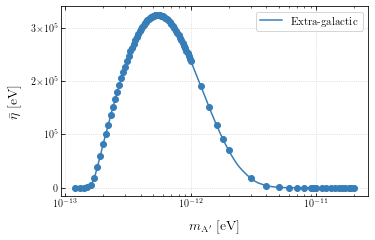

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
plt.grid(ls=':', color='lightgray', alpha=1)

masslist_old = dictKey
ff6 = interpolate.interp1d(masslist_old, avtaulist[0]*baseline, kind='quadratic')
masslist = np.geomspace(masslist_old[0], masslist_old[-1], 200)

plt.plot(masslist, ff6(masslist), color=cych[0], alpha=1, label=r'$\rm Extra$-$\rm galactic$')
plt.plot(masslist_old, avtaulist[0]*baseline, marker='o', ls='None', color=cych[0], alpha=1)

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\eta}  \; [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

ax.set_xscale('log')

a=ax.get_yticks().tolist()[1::2]
ax.set_yticks(a)
a = [fmt(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

plt.legend(loc='best')
plt.savefig('./plots/monopoles.pdf', rasterize=True)
plt.show()

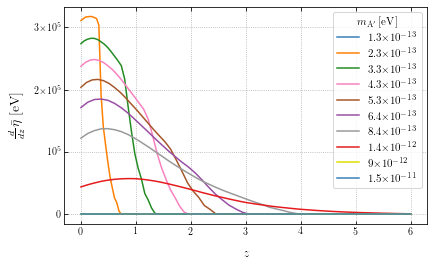

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
cychlic = cycle(cych)
for mind, MA in enumerate(dictKey):
    if mind%10!=1: continue
    iind = next(cychlic)
    lab2 = r'{}'.format(fmt(MA))
    lss = '-'

    ax.plot(zsList[0, mind], dtaudzlist[0, mind]*baseline, color=iind, ls=lss, label=lab2)

ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, loc=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

a=ax.get_yticks().tolist()[1::2]
ax.set_yticks(a)
a = [fmt(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()


/tmp/ipykernel_45929/3474238805.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log'); ax.set_yscale('log')


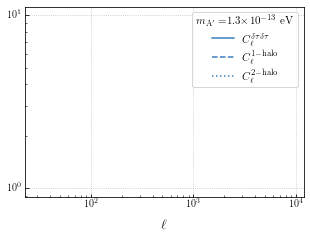

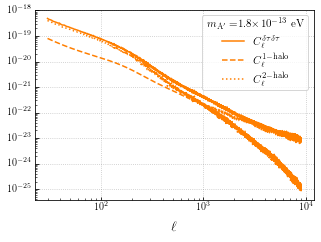

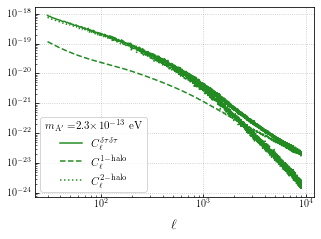

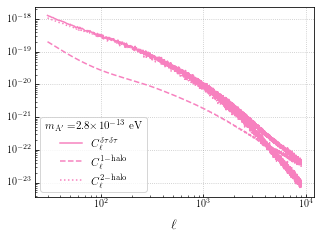

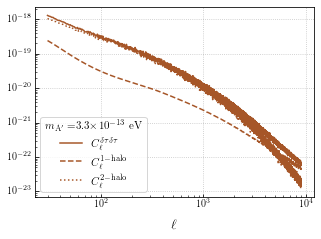

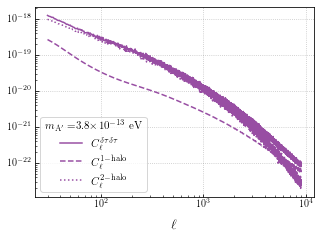

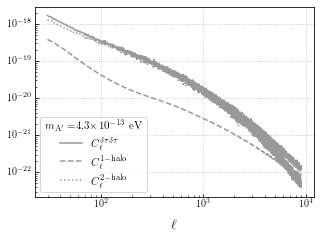

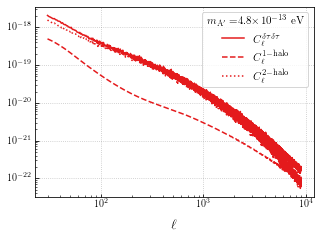

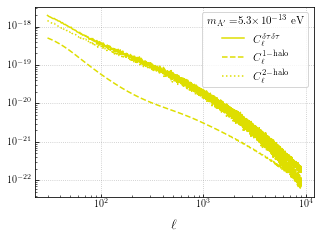

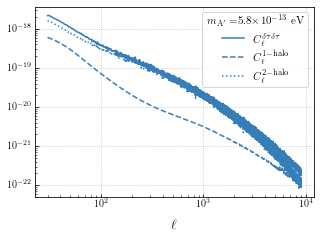

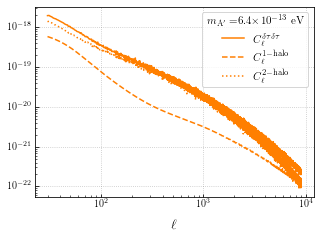

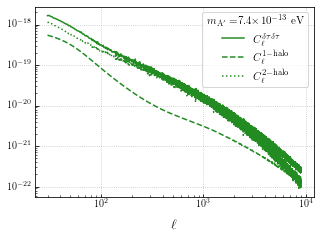

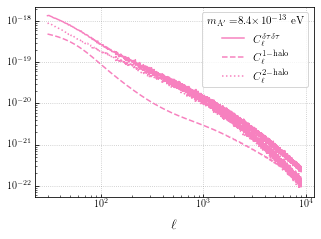

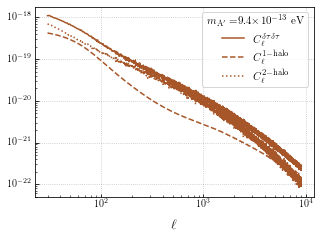

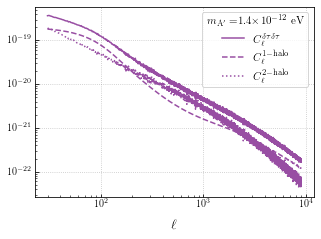

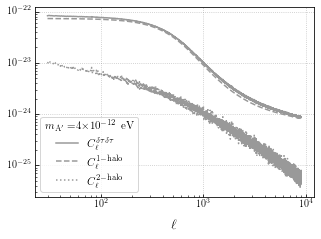

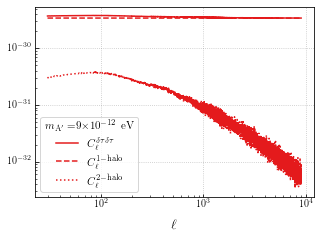

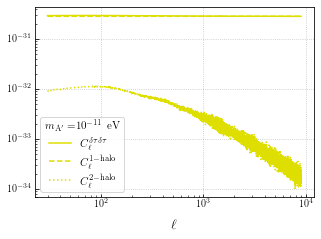

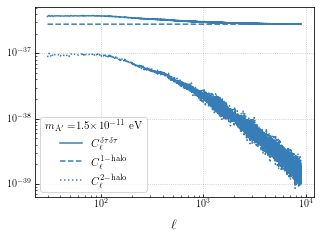

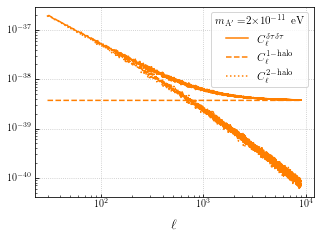

In [15]:
labs = [r'$C_\ell^{\delta\tau\delta\tau}$', r'$C_\ell^{1-{\rm halo}}$', r'$C_\ell^{2-{\rm halo}}$']
varep = 1e-6
cychlic = cycle(cych)

mm, mmm, ct = 30, 9000, 0
for mind, MA in list(enumerate(dictKey)):
    if mind%5!=1: continue
    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
    iind = next(cychlic)
    lab1 = r'{}'.format(fmt(MA))

    ax.plot(ells[mm:mmm], varep**4. * CellTauTau[0, mind, mm:mmm]*baseline**2., alpha=1, color=iind, label=labs[0])
    ax.plot(ells[mm:mmm], varep**4. * Cell1Hdata[0, mind, mm:mmm], ls='--', alpha=1, color=iind, label=labs[1])
    ax.plot(ells[mm:mmm], varep**4. * Cell2Hdata[0, mind, mm:mmm], ls=':', alpha=1, color=iind, label=labs[2])

    ax.legend(loc='best', ncol=1, title=r'$m_{\rm A^{\prime}} =$'+str(fmt(MA))+r' $\rm eV$')
    ax.tick_params(which='both', axis="y", direction="in")
    ax.tick_params(which='both', axis="x", direction="in")
    ax.set_xlabel(r'$\ell$')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.grid(ls=':', color='gray', alpha=0.5)
   # plt.savefig('./plots/gas_celltautau.pdf', rasterize=True)
    plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


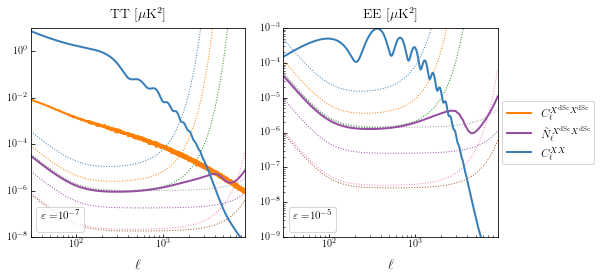

In [18]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname!='CMBS4': continue
    if expname=='Planck':
        mm, mmm = 30, 5000
    else:
        mm, mmm = 30, 9000

    mind = 50
    MA = dictKey[mind]

    freqs = experiment['freqsGHz']
    Nell  = noise(ells, experiment)
    ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))

    fig = plt.figure(figsize=(8, 3.5))
    gs = gridspec.GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    lssp = ['-', '--', ':']
    allp = [1, 0.6, 0.3]

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lab0 = (r'$C_{\ell}^{XX}$' if ii==len(ax)-1 else None)
        lab2 = (r'$C_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)
        lab3 = (r'$\tilde{N}_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)

        for jj in range(len(freqs)):
            labfreq = ('{} GHz'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(Nell[ii, mm:mmm, jj]), color=cych[jj], linewidth=1, ls=':')

        if ii==0:
            epsilon = 1e-7 #8e-11 # TT
        elif ii==1:
            epsilon = 1e-5 #7e-7  # EE, TE

        ax[ii].plot(ells[mm:mmm], preqs*(epsilon**4. * Screening[0, mind, ij, mm:mmm]), color=cych[1], linewidth=2, ls='-', label=lab2)
        ax[ii].plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[5], linewidth=2, label=lab3)
        ax[ii].plot(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ij]), color=cych[0], linewidth=2, label=lab0)

        ax[ii].legend(title=r'$\varepsilon=$'+str(fmt(epsilon)),loc=3)# + r', $m_{\rm A^{\prime}}=$'+r'{}'.format(fmt(MA))+r'$ \, [{\rm eV}]$', loc=1)

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1)#, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
    ax[len(ax)-1].set_xscale('log', subsx=[]); ax[len(ax)-1].set_yscale('log', subsy=[])
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].set_ylim((1.1e50, 2e50)); ax[len(ax)-1].set_xlim((1.1e50, 2e50))

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')
        ax.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim((mm,mmm))
        if ai==0: ax.set_ylim((1e-8,10))
        elif ai==1: ax.set_ylim((1e-9,1e-3))
    plt.savefig('./plots/comparisons'+str(expname)+'.pdf', rasterize=True)
    plt.show()

#### Contour Plot

(97, 3, 1)


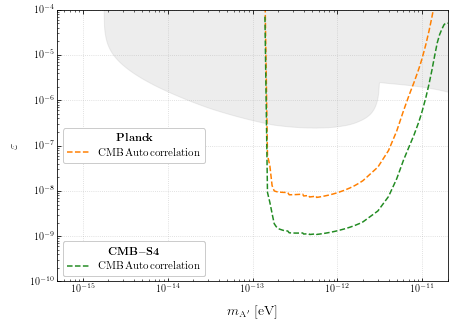

In [20]:
constraint = [r'$\rm CMB \, Autocorrelation$', \
              r'${\rm CMB} \times {\rm LSS}$', \
           #   r'${\rm Reconstruction} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

fig, ax = plt.subplots(1,1, figsize = (7,5))
lssss = ['--', '-', ':', '-.', ':']

datashape = np.shape(sigmaEpsilonList); print(datashape)
for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if eind==2: continue
    secondary_lines, secondary_labels = [], []

    for method in range(datashape[-1]):
        col = [cych[1], cych[2], cych[5]][eind]
        lss = lssss[method]

        l1, = plt.plot(dictKey, sigmaEpsilonList[:, eind, method], color=col, ls=lss)
  #      plt.plot(dictKey, sigmaEpsilonList[:, eind, method], 'o', color=col)
        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, fancybox=True, framealpha=1, loc=['center left',3,2][eind]))
plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((5e-16, 2e-11))
plt.ylim((1e-10, 1e-4))
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')

plt.grid(ls=':', color='darkgray', alpha=0.5)
plt.savefig('./plots/gas_contours.pdf', rasterize=True)
plt.show()
